In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from tqdm import tqdm

## FACTIVA

In [2]:
pac_dir = os.getcwd() + "/../pacnews/"

for file in os.listdir(pac_dir):
    file = pac_dir + file
    if "Factiva" in file and ".txt" in file:
        new_file_name = (file.replace("Factiva-", "")
                             .replace("2023", "")
                             .replace(r"(", "")
                             .replace(r")", "")
                             .replace(" ", ""))    
        os.rename(file, new_file_name)
        
filepaths = [pac_dir + file for file in os.listdir(pac_dir) if ".txt" in file]

Converting RTF file to TXT by following commands on Mac:
`textutil -convert txt *.rtf`

In [3]:
news_info = {"title": [], "date": [], "news": []}
for fp in filepaths: 
    with open(fp, 'r') as file:
        text = file.read()
        entries = text.split("\x0c")
        for idx, entry in enumerate(entries):
            entry_lst = entry.strip().split("\n\n")
            title = entry_lst[0]
            date = entry_lst[1].split("\n")[1]
            if "words" in date:
                date = entry_lst[1].split("\n")[2]
            entry_length = len(entry_lst)
            if idx == len(entries) - 1:
                content = "".join((entry_lst[i]) for i in range(entry_length)
                                  if i > 1 and i < entry_length - 5)
            else:
                content = "".join((entry_lst[i]) for i in range(entry_length)
                                  if i > 1 and i < entry_length - 2)
            news_info["title"].append(title)
            news_info["date"].append(date)
            news_info["news"].append(content)

In [5]:
news_df = pd.DataFrame(news_info)
news_df["date"] = pd.to_datetime(news_df["date"])
news_df = (news_df.drop_duplicates()
                  .sort_values(by="date", ascending=True)
                  .reset_index(drop=True))
news_df["ym"] = [str(d.year) + "-" + str(d.month) for d in news_df.date]
news_df["news"] = news_df["news"].str.lower()

In [6]:
econ_lst = [
    "economy", "economic", "economics", "business", "commerce", "finance",
    "financial", "industry"
]

uncertain_lst = [
    "uncertain", "uncertainty", "uncertainties", "unknown", "unstable",
    "unsure", "undetermined", "risk", "risky", "not certain", "non-reliable"
]

policy_lst = [
    "government", "governmental", "authorities", "minister", "ministry",
    "parliament", "parliamentary", "tax", "regulation", "legislation",
    "central bank", "cbsi", "imf", "world bank", "international monetary fund",
    "debt"
]


In [7]:
def get_news_count(data: pd.DataFrame, column: str):
    count_df = (data.set_index("date")
                .groupby("ym")[[str(column)]]
                .count()
                .reset_index()
                .rename({str(column): str(column) + "_count"}, axis=1))
    return count_df

def check_epu_category(row, terms):
    return any([word in str(row) for word in terms])

def get_epu_zscore(data: pd.DataFrame) -> pd.Series:
    ratio = data["epu_count"] / data["news_count"]
    mean, std = ratio.mean(), ratio.std()
    z_score = abs(ratio - mean) / std
    return z_score

for (category, term_lst) in zip(["econ", "uncertain", "policy"],
                                [econ_lst, uncertain_lst, policy_lst]):
    news_df[str(category)] = news_df["news"].apply(check_epu_category,
                                                   terms=term_lst)

In [8]:
news_df["epu"] = (news_df.econ == True) & (news_df.uncertain == True) & (news_df.policy==True)
news_count = get_news_count(news_df, "news")
epu_news_count = get_news_count(news_df[news_df.epu==True], "epu")

In [19]:
stat = news_count.merge(epu_news_count, how="left", on="ym").fillna(0)
stat["date"] = pd.to_datetime(stat["ym"])
stat["ratio"] = stat["epu_count"]/stat["news_count"]
stat["ratio"] = stat["ratio"].fillna(0)
pac_mean, pac_std = stat["ratio"].mean(), stat["ratio"].std()
stat["z_score"] = abs(stat["ratio"] - pac_mean)/pac_std

In [20]:
target_dir = os.getcwd() + "/data/text/pac/"
news_20 = pd.read_csv(target_dir+"pac_news_2020-23.csv").drop("Unnamed: 0", axis=1)
news_20["news"] = news_20["news"].str.lower()

dates = []
for i in news_20["url"]:
    i = i.replace("https://pina.com.fj/", "")
    date = ("".join(j+"/" for j in i.split("/")[:3]))
    dates.append(date)

news_20["date"] = dates
news_20["date"] = pd.to_datetime(news_20["date"])
news_20["ym"] = [str(d.year) + "-" + str(d.month) for d in news_20.date]

In [21]:
for (category, term_lst) in zip(["econ", "uncertain", "policy"],
                                [econ_lst, uncertain_lst, policy_lst]):
    news_20[str(category)] = news_20["news"].apply(check_epu_category,
                                                   terms=term_lst)

news_20["epu"] = (news_20.econ == True) & (news_20.uncertain == True) & (news_20.policy == True)
news_20_count = get_news_count(news_20, "news")
epu_20_count = get_news_count(news_20[news_20.epu==True], "epu")
stat20 = news_20_count.merge(epu_20_count, how="left")
stat20["ratio"] = (stat20["epu_count"]/stat20["news_count"]).fillna(0)
stat20["z_score"] = abs(stat20["ratio"] - pac_mean) / (pac_std)
scaling_factor = 100/stat["z_score"].mean()
stat20["epu_index"] = scaling_factor * stat20["z_score"]
stat["epu_index"] = scaling_factor * stat["z_score"]

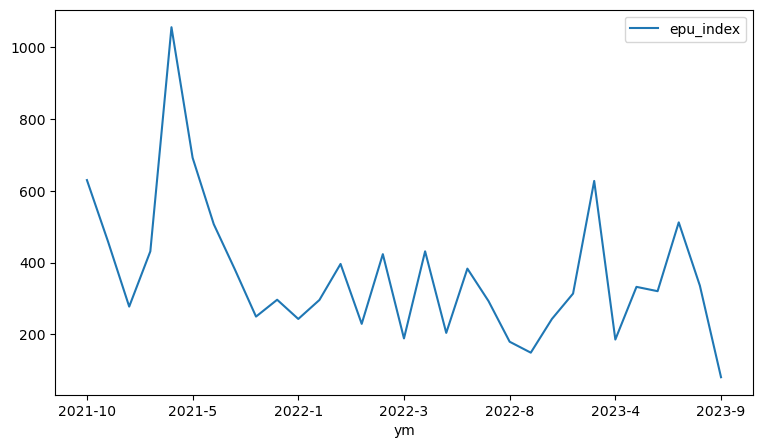

In [33]:
fig, ax = plt.subplots(figsize=(9, 5))
stat20.plot(x="ym", y="epu_index", ax=ax);

## Scraping

In [2]:
url_info = {"url": [], "title": [], "date": [], "category": []}
page_range = range(1, 421)

with tqdm(total=len(page_range)) as pbar:
    for i in page_range:
        content = load_page("https://pina.com.fj/category/news/page/" + str(i),
                            5)
        soup = BeautifulSoup(content)
        for item in soup.find_all(
                class_="td_module_10 td_module_wrap td-animation-stack"):
            title = item.find("h3").text
            url = item.find("h3").find("a")["href"]
            date = item.find(class_="td-post-date")
            category = item.find(class_="td-post-category")
            url_info["url"].append(url)
            url_info["title"].append(title)
            url_info["date"].append(date.text)
            url_info["category"].append(category.text)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████| 420/420 [24:55<00:00,  3.56s/it]


In [6]:
pac_urls = pd.DataFrame(url_info).drop_duplicates().reset_index(drop=True)
pac_urls["date"] = pd.to_datetime(pac_urls["date"])

target_dir = os.getcwd() + "/data/text/pac/"
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    pac_urls.to_csv(target_dir + "pac_news_urls.csv", encoding="utf-8")

In [41]:
def extract_news_pac(url: str):
    content = load_page(url, 5)
    soup = BeautifulSoup(content)
    news = soup.find(class_="td-post-content tagdiv-type").text
    tags_lst = soup.find(class_="td-post-source-tags").find_all("li")
    tags = "".join(i.text.lower() + " " for i in tags_lst if i.text.lower() != "tags")
    return [url, news, tags]

In [42]:
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
import multiprocessing

max_workers = multiprocessing.cpu_count() + 4
output = []
urls = pac_urls.url.tolist()

with tqdm(total=len(urls), unit="pages") as pbar:
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_url = {
            executor.submit(extract_news_pac, url): url
            for url in urls
        }
        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                data = future.result()
            except Exception as exc:
                print('%r generated an exception: %s' % (url, exc))
            else:
                output.append(data)
                pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████| 4200/4200 [50:40<00:00,  1.38pages/s]


In [50]:
pac_news = pd.DataFrame(output, columns=["url", "news", "tag"])
pac_news["news"] = pac_news["news"].str.replace("\n", "")
pac_news.to_csv(target_dir+"pac_news_2020-23.csv", encoding="utf-8")